#### 1. For Prophet: Rename columns as required for it to run df_prophet = df[['Datetime', 'PJMW_MW']].rename(columns={'Datetime': 'ds', 'PJMW_MW': 'y'})

#### 2. For LSTM/CNN/Transformer: Create supervised learning structure (lag features) Example: Create lag features for previous 24 hours

#### 3. For XGBoost and other ML models: Add rolling statistics


####  4. Missing Timestamps vs. Missing Values Sometimes, you have missing timestamps (hours/days with no row at all). Sometimes, you have missing values (row exists, but the value is NaN). For most time series models, you need a continuous time index (no missing timestamps).

#### 5. Stationarity Many models (like ARIMA) assume the data is stationary (mean and variance do not change over time). You can check this visually (rolling mean/std) or with statistical tests.

#### 6. will use MAE, RMSE,MAPE for all models and R^2 except for ARIMA , Prophet

#### 7. the 23 in datatime represents the hour of the day as 23:00 (11 PM)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read csv file
df = pd.read_csv("X:/research paper-implementation/PJMW_hourly.csv")

In [3]:
df

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
...,...,...
143201,2018-01-01 20:00:00,8401.0
143202,2018-01-01 21:00:00,8373.0
143203,2018-01-01 22:00:00,8238.0
143204,2018-01-01 23:00:00,7958.0


In [4]:
#check for max and min values of PJMW_MW only
print("Max value in the dataset:", df['PJMW_MW'].max())
print("Min value in the dataset:", df['PJMW_MW'].min())

Max value in the dataset: 9594.0
Min value in the dataset: 487.0


In [5]:
#check for the max and min values rows , for knowing the time of occurrence 
max_row = df[df['PJMW_MW'] == df['PJMW_MW'].max()]
min_row = df[df['PJMW_MW'] == df['PJMW_MW'].min()]
print("Row with max value:\n", max_row)
print("Row with min value:\n", min_row)


Row with max value:
                    Datetime  PJMW_MW
119310  2015-02-20 08:00:00   9594.0
Row with min value:
                   Datetime  PJMW_MW
11828  2003-05-29 00:00:00    487.0


In [6]:
# Ensure Datetime column is in datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Check the max megawat for each year
max_per_year = df.groupby(df['Datetime'].dt.year)['PJMW_MW'].max()
print("Max megawat for each year:\n", max_per_year)
# Check the min megawat for each year
min_per_year = df.groupby(df['Datetime'].dt.year)['PJMW_MW'].min()
print("Min megawat for each year:\n", min_per_year)




Max megawat for each year:
 Datetime
2002    8300.0
2003    8437.0
2004    8598.0
2005    8823.0
2006    8734.0
2007    8664.0
2008    8426.0
2009    8541.0
2010    8620.0
2011    8998.0
2012    8524.0
2013    8677.0
2014    9349.0
2015    9594.0
2016    8755.0
2017    8503.0
2018    9342.0
Name: PJMW_MW, dtype: float64
Min megawat for each year:
 Datetime
2002    3621.0
2003     487.0
2004    3793.0
2005    3837.0
2006    3428.0
2007    3466.0
2008    3436.0
2009    3213.0
2010    3276.0
2011    3347.0
2012    2553.0
2013    3197.0
2014    3357.0
2015    3526.0
2016    3420.0
2017    3475.0
2018    3687.0
Name: PJMW_MW, dtype: float64


In [7]:
#check the month and day for the year of 2003 for the min value
min_row_2003 = df[(df['Datetime'].dt.year == 2003) & (df['PJMW_MW'] == df['PJMW_MW'].min())]
print("Row with min value in 2003:\n", min_row_2003)

Row with min value in 2003:
         Datetime  PJMW_MW
11828 2003-05-29    487.0


In [8]:
#change into datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')

In [9]:
#Sort by datetime to ensure correct order.
df = df.sort_values(by='Datetime')

In [10]:
#check for null values
df.isnull().sum()

Datetime    0
PJMW_MW     0
dtype: int64

In [11]:
#identify duplicate rows
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


In [12]:
#Check the time range (start/end dates)
start_date = df['Datetime'].min()
end_date = df['Datetime'].max()
print(f"Data covers the period from {start_date} to {end_date}")

Data covers the period from 2002-04-01 01:00:00 to 2018-08-03 00:00:00


In [13]:
# 1. Check for missing timestamps (important for ARIMA, Prophet, LSTM, etc.)
full_range = pd.date_range(start=df['Datetime'].min(), end=df['Datetime'].max(), freq='H')
missing_timestamps = set(full_range) - set(df['Datetime'])
print(f"Number of missing hourly timestamps: {len(missing_timestamps)}")

Number of missing hourly timestamps: 30


In [14]:
missing_df = pd.DataFrame(missing_timestamps, columns=['Datetime'])
missing_df['PJMW_MW'] = np.nan  # Fill with NaN for visualization
df = pd.concat([df, missing_df]).sort_values(by='Datetime').reset_index(drop=True)


In [15]:
##check for null values again for the second time
df.isnull().sum()

Datetime     0
PJMW_MW     30
dtype: int64

##### elsabb en awel mra mkn4 feh nulls we en tany mra b2a --> Original data: No nulls, but some hours are missing entirely (no row for that hour).#After adding missing timestamps: Now every hour is present, but for the hours that were missing in the original data, 'PJMW_MW' is NaN.
##### This is expected and is a standard approach for time series analysis, especially for models that require a continuous time index (like ARIMA, Prophet, LSTM, etc.).

In [16]:
#print the rows with missing timestamps
missing_rows = df[df['Datetime'].isin(missing_timestamps)]
print("Rows with missing timestamps:")
print(missing_rows)


# NOTE : eldata kolha btb2a dayman els3a 2 we 3

Rows with missing timestamps:
                  Datetime  PJMW_MW
146    2002-04-07 03:00:00      NaN
5017   2002-10-27 02:00:00      NaN
8882   2003-04-06 03:00:00      NaN
13753  2003-10-26 02:00:00      NaN
17618  2004-04-04 03:00:00      NaN
22657  2004-10-31 02:00:00      NaN
26354  2005-04-03 03:00:00      NaN
31393  2005-10-30 02:00:00      NaN
35090  2006-04-02 03:00:00      NaN
40129  2006-10-29 02:00:00      NaN
43322  2007-03-11 03:00:00      NaN
49033  2007-11-04 02:00:00      NaN
52058  2008-03-09 03:00:00      NaN
57769  2008-11-02 02:00:00      NaN
60794  2009-03-08 03:00:00      NaN
66505  2009-11-01 02:00:00      NaN
69698  2010-03-14 03:00:00      NaN
75409  2010-11-07 02:00:00      NaN
76199  2010-12-10 00:00:00      NaN
78434  2011-03-13 03:00:00      NaN
84145  2011-11-06 02:00:00      NaN
87170  2012-03-11 03:00:00      NaN
92881  2012-11-04 02:00:00      NaN
95906  2013-03-10 03:00:00      NaN
101617 2013-11-03 02:00:00      NaN
104642 2014-03-09 03:00:00      Na

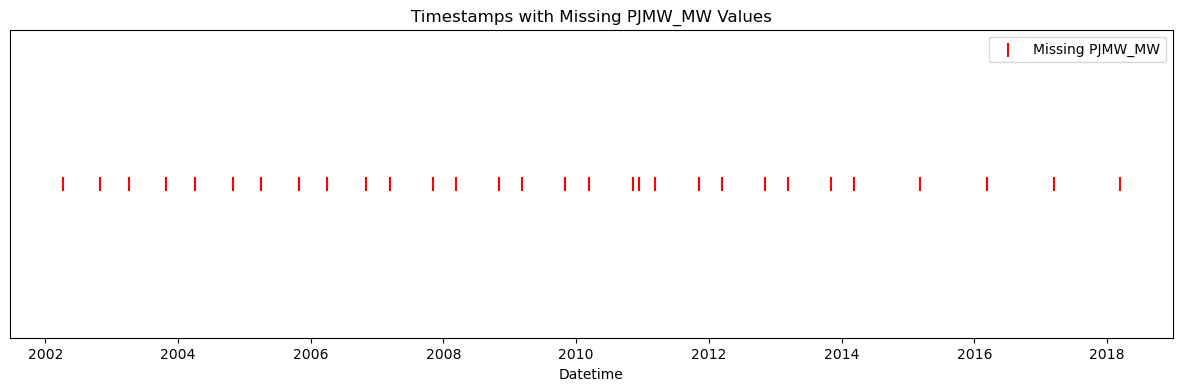

In [17]:
# Visualize timestamps with null PJMW_MW values
plt.figure(figsize=(15, 4))
plt.scatter(df[df['PJMW_MW'].isnull()]['Datetime'], [0]*df['PJMW_MW'].isnull().sum(), 
            color='red', marker='|', s=100, label='Missing PJMW_MW')
plt.title('Timestamps with Missing PJMW_MW Values')
plt.xlabel('Datetime')
plt.yticks([])
plt.legend()
plt.show()

#### best two approaches used to impute the Nan values in time series are 
#### 1. linear interpolation , 2. forward fill (ffill)
#### each one is better with its own some models but preferably use linear interpolation for our models (Arima , prophet , XGBoost, LSTM , CNN , Transformer)

In [18]:
# Set Datetime as index for time-based interpolation
df = df.set_index('Datetime')
df['PJMW_MW'] = df['PJMW_MW'].interpolate(method='time')
df = df.reset_index()

In [19]:
#idenfity outliers
outliers = df[(df['PJMW_MW'] < df['PJMW_MW'].quantile(0.01)) | (df['PJMW_MW'] > df['PJMW_MW'].quantile(0.99))]
print(f"Number of outliers: {len(outliers)}")

Number of outliers: 2865


#### check if there is any something weird or could be improved across the whole all these years

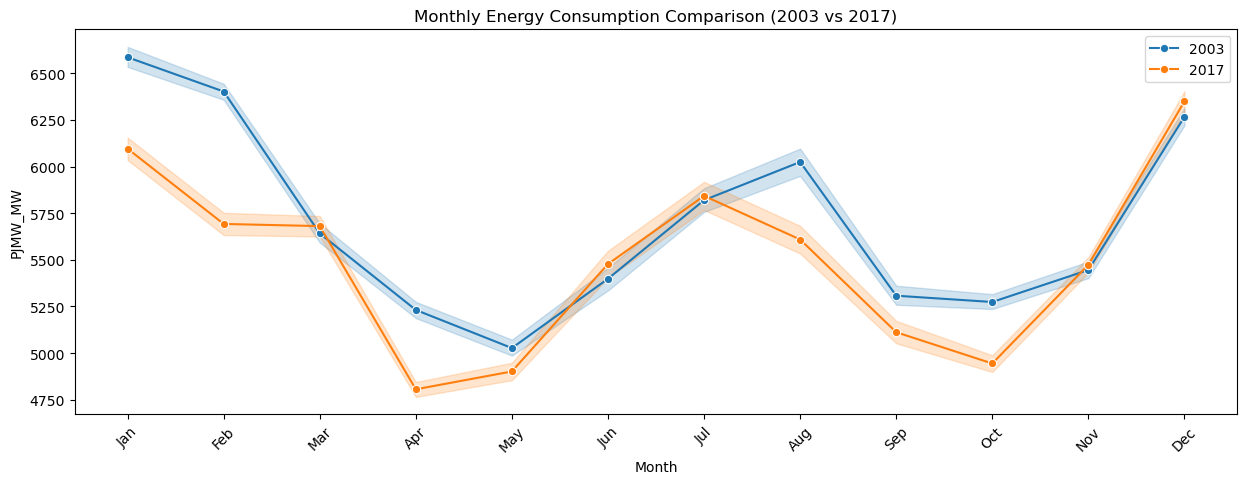

In [33]:
#compare between 2003 and 2017
plt.figure(figsize=(15, 5))
sns.lineplot(data=df[df['Datetime'].dt.year == 2003], x='Month', y='PJMW_MW', marker='o', label='2003')
sns.lineplot(data=df[df['Datetime'].dt.year == 2017], x='Month', y='PJMW_MW', marker='o', label='2017')
plt.title("Monthly Energy Consumption Comparison (2003 vs 2017)")
plt.xlabel("Month")
plt.ylabel("PJMW_MW")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar',
                            'Apr', 'May', 'Jun', 'Jul', 'Aug', 
                            'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend()
plt.show()

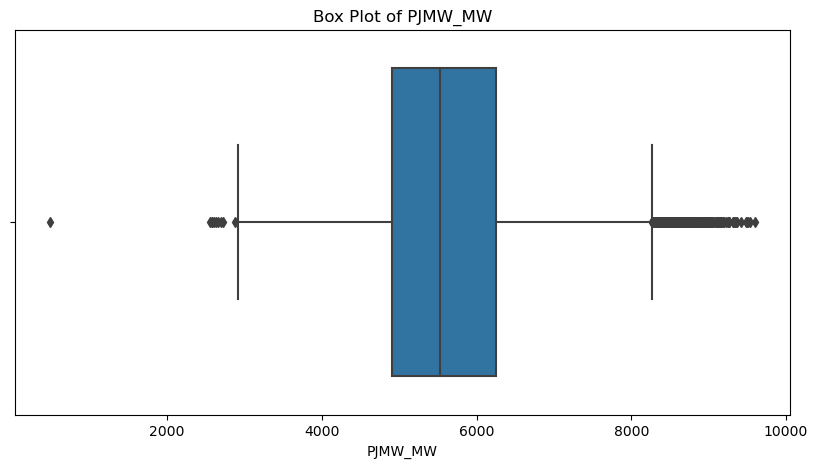

In [20]:
#box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['PJMW_MW'])
plt.title('Box Plot of PJMW_MW')
plt.xlabel('PJMW_MW')
plt.show()

In [21]:
#check for the rows of outliers
outlier_hours = outliers['Datetime'].dt.hour.value_counts().sort_index()
outlier_hours


Datetime
0      15
1      42
2     145
3     247
4     326
5     294
6     239
7     191
8     120
9      77
10     57
11     45
12     39
13     44
14     75
15     92
16    115
17    137
18    153
19    155
20    111
21     82
22     46
23     18
Name: count, dtype: int64

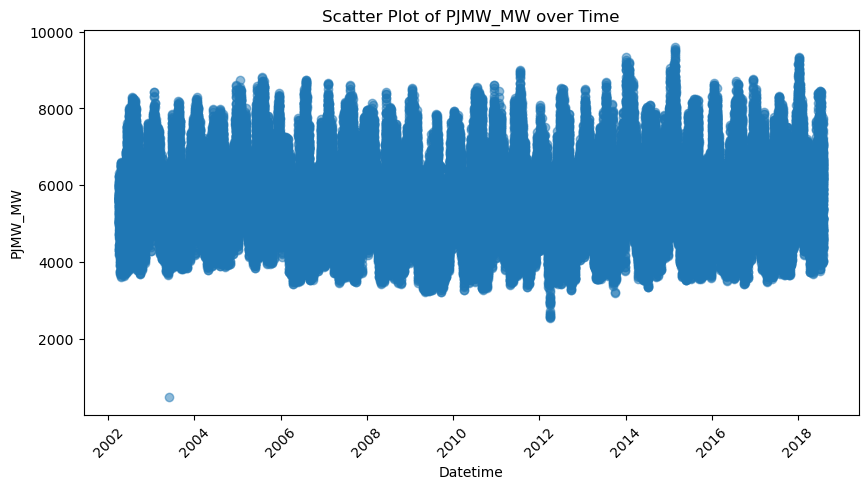

In [22]:
#scatter plots
plt.figure(figsize=(10, 5))
plt.scatter(df['Datetime'], df['PJMW_MW'], alpha=0.5)
plt.title('Scatter Plot of PJMW_MW over Time')
plt.xlabel('Datetime')
plt.ylabel('PJMW_MW')
plt.xticks(rotation=45)
plt.show()

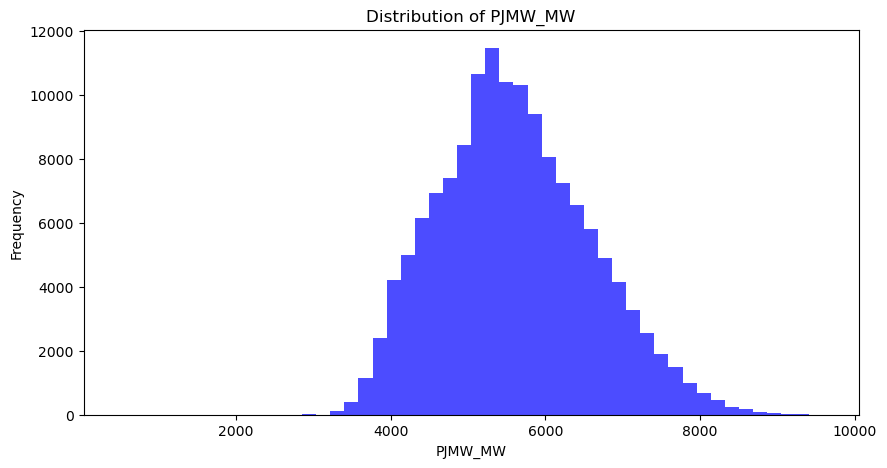

In [23]:
#histogram for checking skewness
plt.figure(figsize=(10, 5))
plt.hist(df['PJMW_MW'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of PJMW_MW')
plt.xlabel('PJMW_MW')
plt.ylabel('Frequency')
plt.show()



#### mafe4 ay skewness, the data is normally distributed wel outliers are not significant enough to affect the analysis.

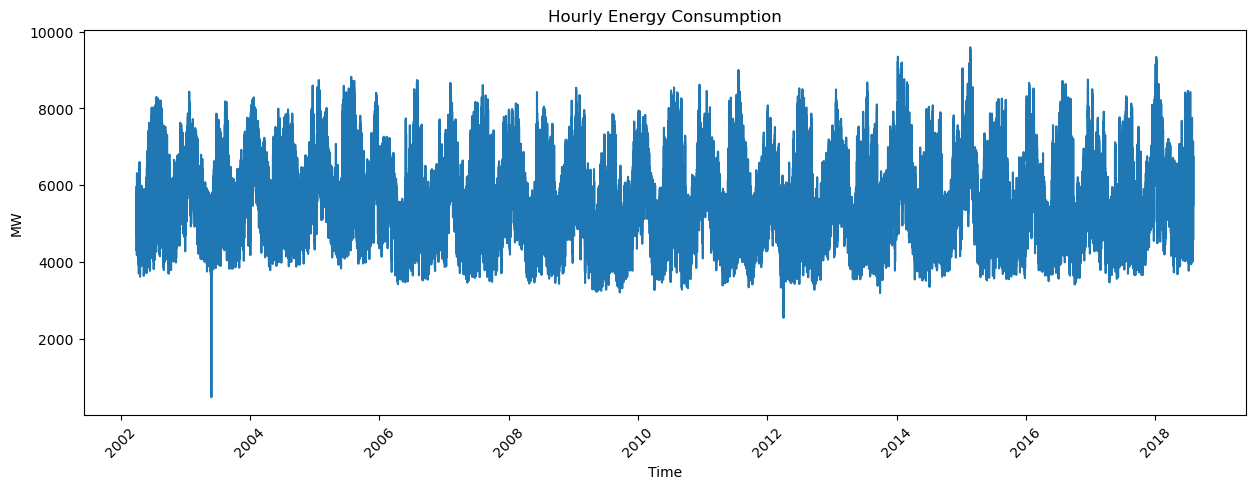

In [24]:
#visualize the time series data by seaborn
plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x='Datetime', y='PJMW_MW')
plt.title("Hourly Energy Consumption")
plt.xlabel("Time")
plt.ylabel("MW")
plt.xticks(rotation=45)
plt.show()

In [ ]:
#the plot shows the energy consumption over time, with peaks 
#and troughs indicating periods of high and low demand.  
#The data is not stationary because the rolling mean and 
#standard deviation change over time.
#This means there are trends (long-term increases or decreases) 
# and seasonality (regular repeating patterns, like daily or
# yearly cycles).
#In time series analysis, non-stationary data can affect model 
# performance, so we often need to transform it to make it stationary. which is common in energy consumption data.

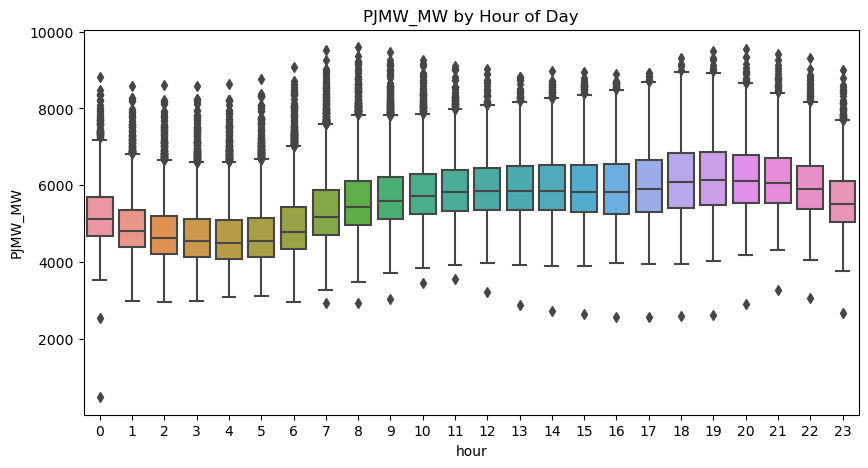

In [ ]:
#box plot of Energy consumption usage across the hour of day
plt.figure(figsize=(10,5))
sns.boxplot(x='hour', y='PJMW_MW', data=df)
plt.title('PJMW_MW by Hour of Day')
plt.show()

In [ ]:
#this graph shows that the energy consumption is not constant over time(not stationatry), 
# and there are periods of high and low variability.

In [37]:
df['hour'] = df['Datetime'].dt.hour                # Hour of day (0-23)
df['day_of_week'] = df['Datetime'].dt.dayofweek    # Monday=0, Sunday=6
df['month'] = df['Datetime'].dt.month              # Month (1-12)

In [38]:
#the dataframe started with 6574 row not 0
df

,Datetime,PJMW_MW,Month,hour,day_of_week,month
0,2002-04-01 01:00:00,4374.0,4,1,0,4
1,2002-04-01 02:00:00,4306.0,4,2,0,4
2,2002-04-01 03:00:00,4322.0,4,3,0,4
3,2002-04-01 04:00:00,4359.0,4,4,0,4
4,2002-04-01 05:00:00,4436.0,4,5,0,4
...,...,...,...,...,...,...
143231,2018-08-02 20:00:00,6545.0,8,20,3,8
143232,2018-08-02 21:00:00,6496.0,8,21,3,8
143233,2018-08-02 22:00:00,6325.0,8,22,3,8
143234,2018-08-02 23:00:00,5892.0,8,23,3,8


In [39]:
#this code to fix the sorting issue
df = df.sort_values(by='Datetime').reset_index(drop=True)

In [40]:
#the issue solved as we can see the dataframe now starts with 0
df.head()

,Datetime,PJMW_MW,Month,hour,day_of_week,month
0,2002-04-01 01:00:00,4374.0,4,1,0,4
1,2002-04-01 02:00:00,4306.0,4,2,0,4
2,2002-04-01 03:00:00,4322.0,4,3,0,4
3,2002-04-01 04:00:00,4359.0,4,4,0,4
4,2002-04-01 05:00:00,4436.0,4,5,0,4


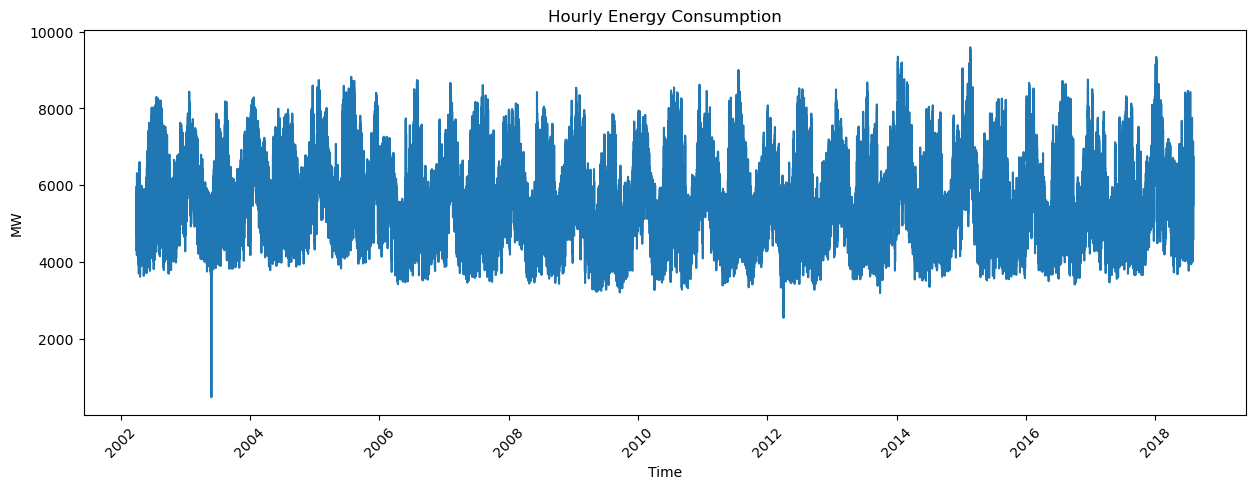

In [41]:
#line plot for PJMW_MW over time
plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x='Datetime', y='PJMW_MW')
plt.title("Hourly Energy Consumption")
plt.xlabel("Time")
plt.ylabel("MW")
plt.xticks(rotation=45)
plt.show()


In [42]:
#Stationarity Check (with Rolling Mean/Std)
rolling_mean = df['PJMW_MW'].rolling(window=24*7).mean()  # 1 week
rolling_std = df['PJMW_MW'].rolling(window=24*7).std()

#### Stationary data: Good for classical time series models (like ARIMA). The model can make reliable predictions.

#### Non-stationary data: Indicates trends or seasonality. You need to transform your data to make it stationary before modeling.

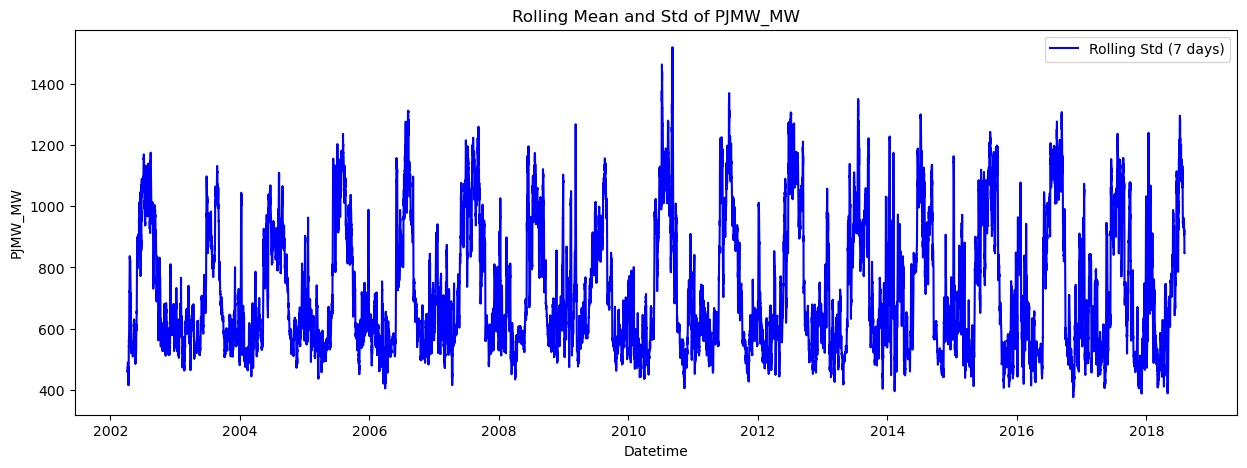

In [43]:
#visalize the rolling_std
plt.figure(figsize=(15, 5))
plt.plot(df['Datetime'], rolling_std, label='Rolling Std (7 days)', color='blue')
plt.title('Rolling Mean and Std of PJMW_MW')
plt.xlabel('Datetime')
plt.ylabel('PJMW_MW')
plt.legend()
plt.show()

In [ ]:
#the graph shows the rolling standard deviation of PJMW_MW over time, with peaks indicating periods of high variability in energy consumption.
#The rolling standard deviation is calculated over a 7-day window, which helps to smooth out
#short-term fluctuations and highlight longer-term trends in variability.
#lets explain the graph more 
# it means that the energy consumption is not constant 
# over time(not stationatry), 
# and there are periods of high and low variability.

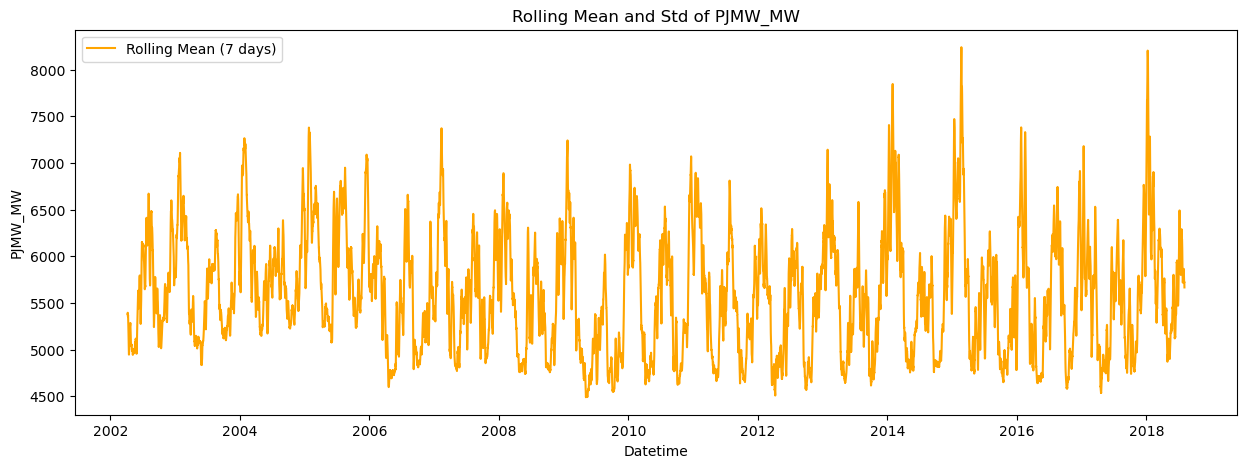

In [45]:
#visualize the rolling_mean 
plt.figure(figsize=(15, 5))
plt.plot(df['Datetime'], rolling_mean, label='Rolling Mean (7 days)', color='orange')
plt.title('Rolling Mean and Std of PJMW_MW')
plt.xlabel('Datetime')
plt.ylabel('PJMW_MW')
plt.legend()
plt.show()

#### merge the original + rolling mean + rolling std to see if there is a pattern or something we could useful extract or even look the same ?

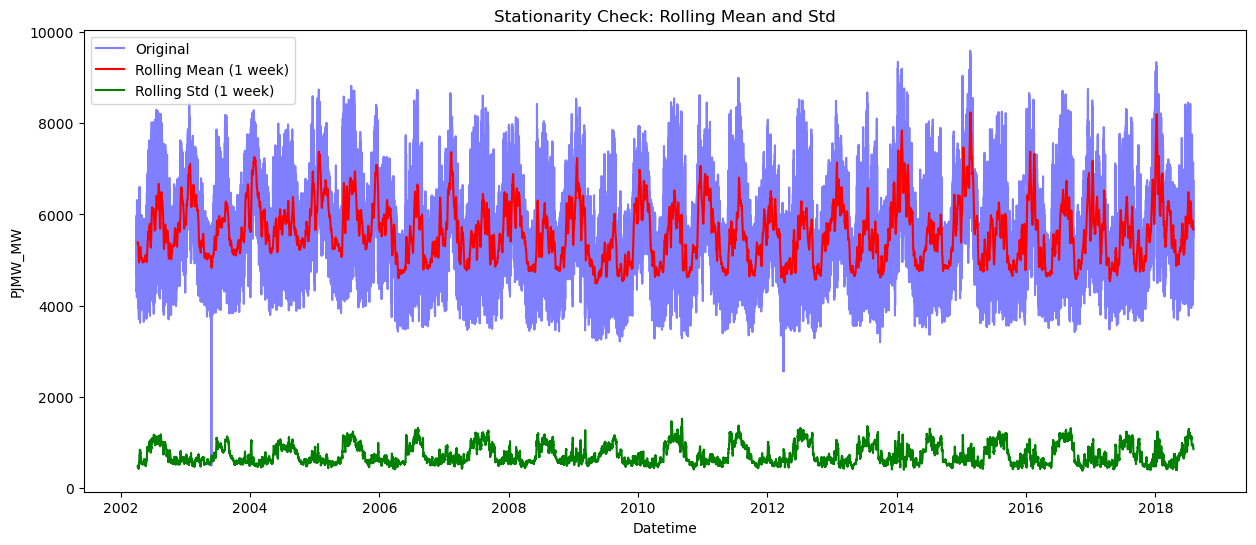

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df['Datetime'], df['PJMW_MW'], label='Original', color='blue', alpha=0.5)
plt.plot(df['Datetime'], rolling_mean, label='Rolling Mean (1 week)', color='red')
plt.plot(df['Datetime'], rolling_std, label='Rolling Std (1 week)', color='green')
plt.title('Stationarity Check: Rolling Mean and Std')
plt.xlabel('Datetime')
plt.ylabel('PJMW_MW')
plt.legend()
plt.show()


# as we see our data is (not stationary) because the rolling mean 
# and std are changing over time, indicating trends or seasonality.

In [66]:
# to make the data stationary, we can use differencing or 
# transformation methods.

In [53]:
# First order differencing
df['PJMW_MW_diff'] = df['PJMW_MW'] - df['PJMW_MW'].shift(1)

# Drop the first row (it will be NaN after differencing)
df_diff = df.dropna(subset=['PJMW_MW_diff'])

In [54]:
df

,Datetime,PJMW_MW,Month,hour,day_of_week,month,PJMW_MW_diff
0,2002-04-01 01:00:00,4374.0,4,1,0,4,NaN
1,2002-04-01 02:00:00,4306.0,4,2,0,4,-68.0
2,2002-04-01 03:00:00,4322.0,4,3,0,4,16.0
3,2002-04-01 04:00:00,4359.0,4,4,0,4,37.0
4,2002-04-01 05:00:00,4436.0,4,5,0,4,77.0
...,...,...,...,...,...,...,...
143231,2018-08-02 20:00:00,6545.0,8,20,3,8,-148.0
143232,2018-08-02 21:00:00,6496.0,8,21,3,8,-49.0
143233,2018-08-02 22:00:00,6325.0,8,22,3,8,-171.0
143234,2018-08-02 23:00:00,5892.0,8,23,3,8,-433.0


In [55]:
# the row number of 0 is NaN due to there is no previous value to subtract from 4374
# the row number 1 it equals -68 due to 4306(previous day) - 4374(current day) and continue on the same way for the next rows

#### after using difference the time series visualization should be in a line  

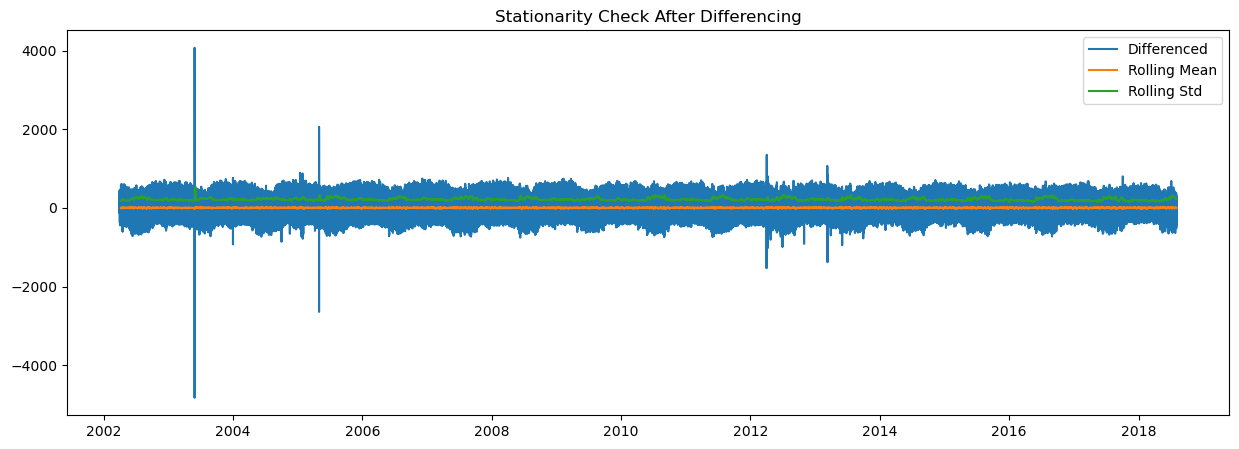

In [56]:
# Plot rolling mean and std for differenced data
plt.figure(figsize=(15, 5))
plt.plot(df_diff['Datetime'], df_diff['PJMW_MW_diff'], 
         label='Differenced')
plt.plot(df_diff['Datetime'], df_diff['PJMW_MW_diff'].
         rolling(window=24*7).mean(), label='Rolling Mean')
plt.plot(df_diff['Datetime'], df_diff['PJMW_MW_diff'].
         rolling(window=24*7).std(), label='Rolling Std')
plt.legend()
plt.title('Stationarity Check After Differencing')
plt.show()

In [57]:
# the graph explain that the differenced data is more stationary than the original data, as the rolling mean and std are more stable over time.
# This indicates that the differencing has removed some of the trends and seasonality from the data

#### use statistical tests like the Augmented Dickey-Fuller (ADF) test to confirm stationarity.

#### If the p-value is less than 0.05, your data is considered stationary.
#### If the p-value is greater than 0.05, your data is still non-stationary and you may need further differencing or transformation.

In [58]:
# Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_diff['PJMW_MW_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


#### p-value is less than 0.05 so it indicates that the 
# differenced data became stationary now and ready for arima model.
#A more negative ADF Statistic = stronger evidence for stationarity.

ADF Statistic: -54.35492228230963
p-value: 0.0


### saving the dataframe of difference for modeling arima because we only need the original one for visualization and analysis and for other models.

In [ ]:
df_diff.to_csv("X:/research paper/PJMW_hourly_diff_arima.csv", index=False)

##### saving the dataframe for modeling prophet because we are going to work on the original one and continue on it for generating new features as lag features for LSTM/CNN/Transformer as well as add rolling statistic (mean , std, min , max) for XGBoost

In [42]:
#drop pjmw_mw_diff column from the original dataframe
df = df.drop(columns=['PJMW_MW_diff'])

In [44]:
#saving the dataframe after preprocessing
df.to_csv("X:/research paper/PJMW_hourly_preprocessed_prophet.csv", index=False)

#### lag_1 = previous hour, lag_24 = same hour yesterday This captures both short-term and daily patterns.

In [59]:
# --- XGBoost Feature Engineering ---

# 1. Lag features (previous 24 hours)
for lag in range(1, 25):
    df[f'lag_{lag}'] = df['PJMW_MW'].shift(lag)

#### The 24-hour window for rolling statistics is chosen because our data is hourly and energy consumption often has daily patterns (seasonality every 24 hours)

In [60]:
# 2. Rolling statistics (24-hour window)
df['rolling_mean_24'] = df['PJMW_MW'].rolling(window=24).mean()
df['rolling_std_24'] = df['PJMW_MW'].rolling(window=24).std()
df['rolling_min_24'] = df['PJMW_MW'].rolling(window=24).min()
df['rolling_max_24'] = df['PJMW_MW'].rolling(window=24).max()

In [61]:
# 3. Drop rows with NaNs (first 24 rows will have NaNs)
df_xgb = df.dropna().reset_index(drop=True)

In [62]:
df_xgb

,Datetime,PJMW_MW,Month,hour,day_of_week,month,PJMW_MW_diff,lag_1,lag_2,lag_3,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_24,rolling_std_24,rolling_min_24,rolling_max_24
0,2002-04-02 01:00:00,4873.0,4,1,1,4,-165.0,5038.0,5406.0,5783.0,...,4723.0,4436.0,4359.0,4322.0,4306.0,4374.0,5282.250000,521.778085,4306.0,5978.0
1,2002-04-02 02:00:00,4768.0,4,2,1,4,-105.0,4873.0,5038.0,5406.0,...,5180.0,4723.0,4436.0,4359.0,4322.0,4306.0,5301.500000,491.859824,4322.0,5978.0
2,2002-04-02 03:00:00,4713.0,4,3,1,4,-55.0,4768.0,4873.0,5038.0,...,5482.0,5180.0,4723.0,4436.0,4359.0,4322.0,5317.791667,463.673515,4359.0,5978.0
3,2002-04-02 04:00:00,4737.0,4,4,1,4,24.0,4713.0,4768.0,4873.0,...,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0,5333.541667,435.237364,4436.0,5978.0
4,2002-04-02 05:00:00,4809.0,4,5,1,4,72.0,4737.0,4713.0,4768.0,...,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,5349.083333,407.574578,4713.0,5978.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143207,2018-08-02 20:00:00,6545.0,8,20,3,8,-148.0,6693.0,6758.0,6708.0,...,5100.0,5363.0,5881.0,6362.0,6571.0,6816.0,5809.250000,762.020384,4572.0,6758.0
143208,2018-08-02 21:00:00,6496.0,8,21,3,8,-49.0,6545.0,6693.0,6758.0,...,4840.0,5100.0,5363.0,5881.0,6362.0,6571.0,5806.125000,758.908101,4572.0,6758.0
143209,2018-08-02 22:00:00,6325.0,8,22,3,8,-171.0,6496.0,6545.0,6693.0,...,4745.0,4840.0,5100.0,5363.0,5881.0,6362.0,5804.583333,757.766507,4572.0,6758.0
143210,2018-08-02 23:00:00,5892.0,8,23,3,8,-433.0,6325.0,6496.0,6545.0,...,4572.0,4745.0,4840.0,5100.0,5363.0,5881.0,5805.041667,757.818062,4572.0,6758.0


#### Lag Features vs. Target : Check if lag features are correlated with the target.

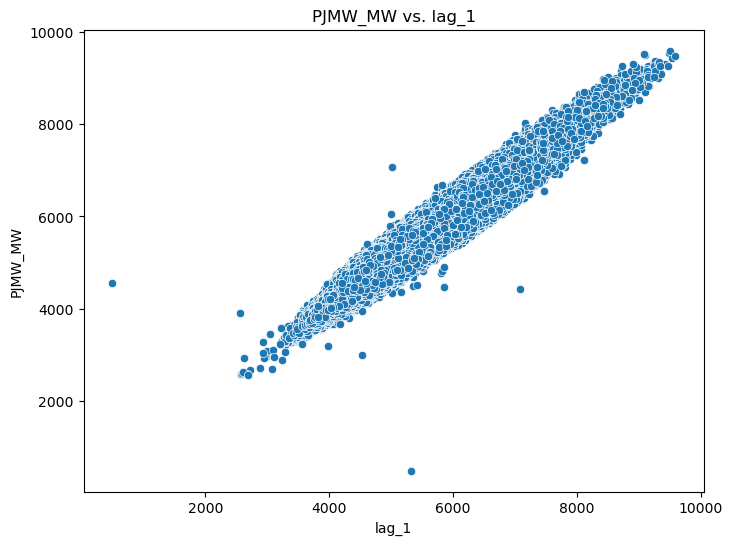

In [63]:
#visualize lag_1 vs. target 
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['lag_1'], y=df['PJMW_MW'])
plt.title('PJMW_MW vs. lag_1')
plt.xlabel('lag_1')
plt.ylabel('PJMW_MW')
plt.show()

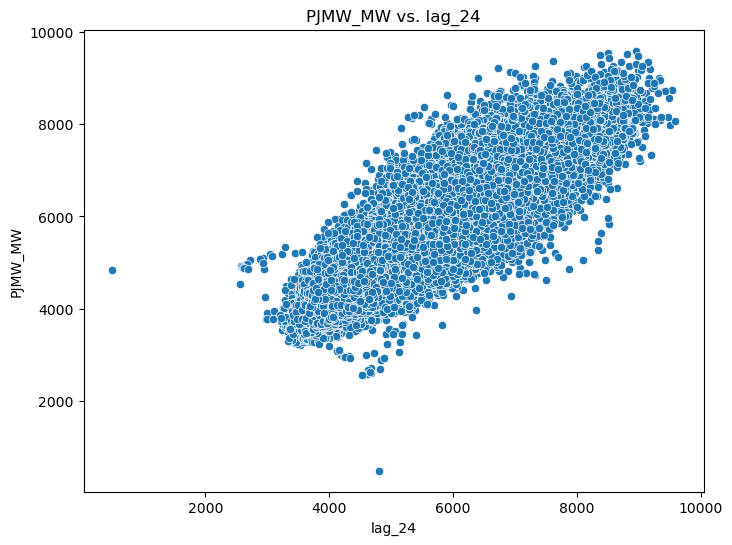

In [64]:
# another one to visualize lag_24 vs. target 
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['lag_24'], y=df['PJMW_MW'])
plt.title('PJMW_MW vs. lag_24')
plt.xlabel('lag_24')
plt.ylabel('PJMW_MW')
plt.show()


####  Rolling Statistics Visualize rolling mean and std to see local trends and volatility.

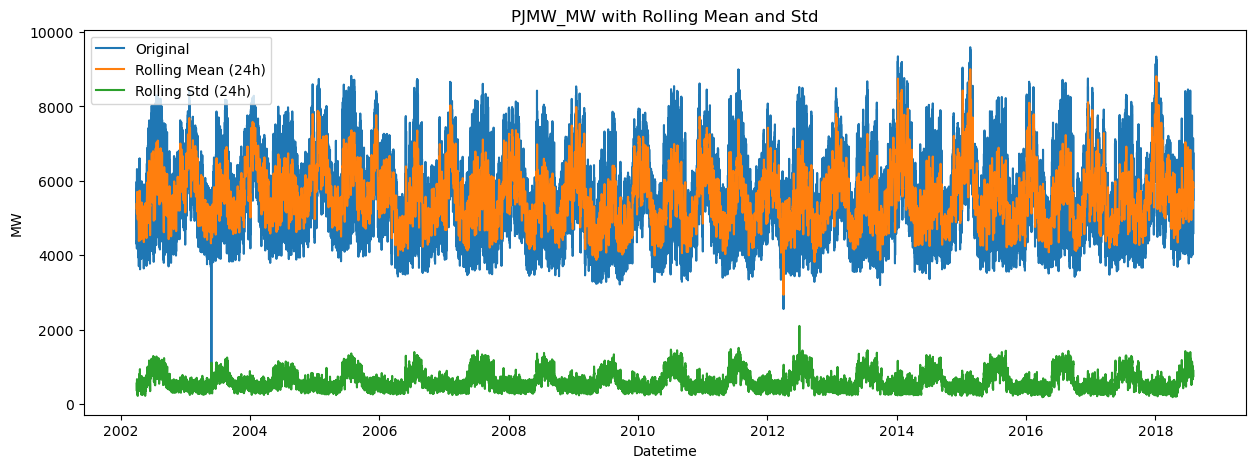

In [65]:
plt.figure(figsize=(15,5))
plt.plot(df['Datetime'], df['PJMW_MW'], label='Original')
plt.plot(df['Datetime'], df['rolling_mean_24'], label='Rolling Mean (24h)')
plt.plot(df['Datetime'], df['rolling_std_24'], label='Rolling Std (24h)')
plt.legend()
plt.title('PJMW_MW with Rolling Mean and Std')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.show()

#### Feature Correlation Heatmap See which features are most correlated with the target.

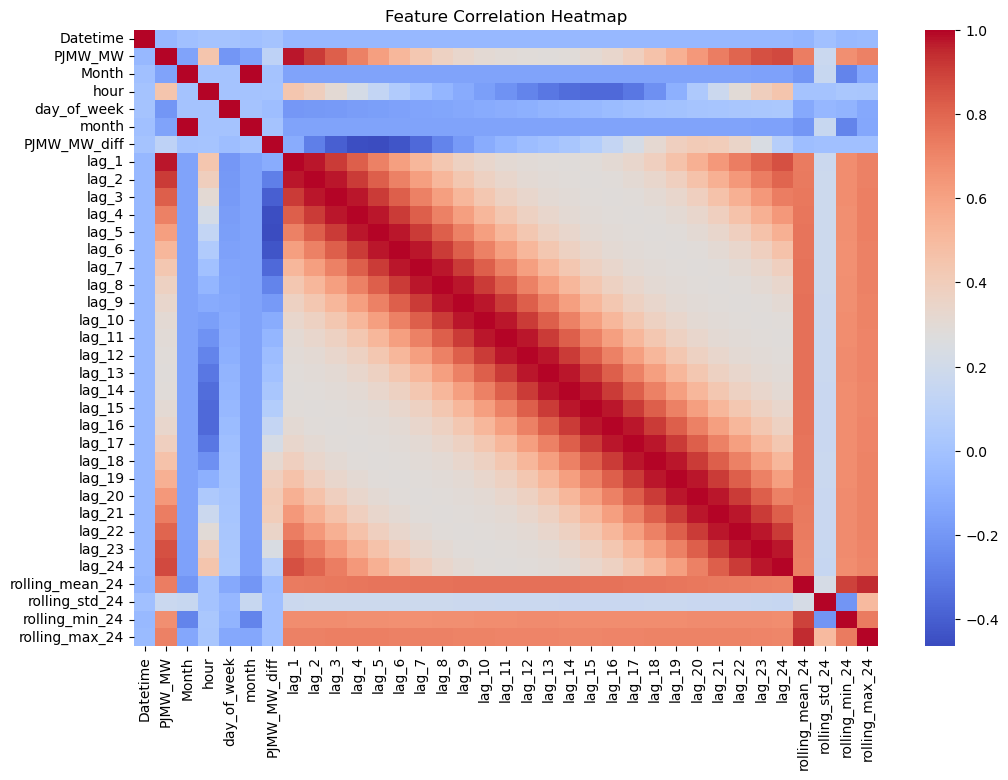

In [66]:
plt.figure(figsize=(12,8))
corr = df_xgb.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
#use corrl

In [67]:
# the heatmap shows that lag_1 and lag_24 are highly 
# correlated with the target PJMW_MW,
# which is expected as they represent the previous hour and 
# the same hour yesterday, respectively.

In [ ]:
# this box plot shows the distribution of PJMW_MW
# across different hours of the day, indicating that energy consumption
# tends to be higher during certain hours 
# (e.g., morning and evening peaks).

In [ ]:
# 4. (Optional) Save for later use
df_xgb.to_csv("X:/research paper/PJMW_hourly_xgboost_lag_rolling.csv", index=False)

##### to be continue for LSTM / CNN / Transformer